# Model-based RL: DYNA-Q

Based on Q-Learning and the theory of MDPs, we can define very simple way of doing model-based RL, called DYNA-Q.

The key idea is to store experiences in an internal model and sample from this experience in offline experience. In essence, this will make learning (much) more efficient.

The structure of the code is inspired by Sutton and Barto, Chapter 8 and based on the DYNA-Q tutorial from Neuromatch 2020 (https://academy.neuromatch.io/nma2020/course-materials).

In this notebook, you have to solve three tasks:


*   Implement the part of DYNA-Q where an experience is stored in a task model
*   Implement a variant of the task where a shortcut appears after 200 trials
*   Explore and describe the role of different parameters, especially $\epsilon$, $\alpha$, $\gamma$, and k


We start with some imports and defining some helper functions - you need to run these but don't need to look at them.

In [3]:
# Imports
import numpy as np                 
import matplotlib.pyplot as plt

In [4]:
# @title Helper functions
from scipy.signal import convolve as conv

def epsilon_greedy(q, epsilon):
    """
    Epsilon-greedy policy: selects maximum value action with probabilty
    (1-epsilon) and selects randomly with epsilon probability.

    Input:
    q: an array of action values
    epsilon: probability of selecting an action randomly 

    Returns:
    action: chosen action
    """

    if np.random.random() > epsilon:
        action = np.argmax(q)
    else:
        action = np.random.choice(len(q)) 

    return action

def q_learning(state, action, reward, next_state, value, params):  
    """
    Q-learning: updates the value function and returns it.

    Input:
    state:  current state identifier
    action: action taken
    reward: reward received
    next_state: transitioned to state identifier
    value: current value function of shape (n_states, n_actions)
    params: a dictionary containing the default parameters

    Returns:
    value: the updated value function of shape (n_states, n_actions)
    """

    # Q-value of current state-action pair
    q = value[int(state), int(action)]

    if next_state is None or np.isnan(next_state):
        max_next_q = 0
    else:
        max_next_q = np.max(value[int(next_state)])

    # reward prediction error
    delta = reward + params['gamma'] * max_next_q - q

    # update value of previous state-action pair
    value[int(state), int(action)] = q + params['alpha'] * delta

    return value

def get_outcome(state, action, shortcut_state=64):  
    """
    100 states (10-by-10 grid world).

    The mapping from state to the grid is as follows:

    90 ...       99
    ...
    40 ...       49
    30 ...       39
    20 21 22 ... 29
    10 11 12 ... 19
    0  1  2  ...  9

    54 is the start state.

    Actions 0, 1, 2, 3 correspond to right, up, left, down.

    Moving anywhere from state 99 (goal state) will end the session.

    Landing in red states incurs a reward of -1.

    Landing in the goal state (99) gets a reward of 1.

    Going towards the border when already at the border will stay in the same place.
    """

    if state == 99:  # goal state
        reward = 0
        next_state = None
        return next_state, reward
    reward = 0  # default reward value
    if action == 0:  # move right
        next_state = state + 1
        if state == 98:  # next state is goal state
            reward = 1
        elif state % 10 == 9:  # right border
            next_state = state
        elif state in [11, 21, 31, 41, 51, 61, 71,
                     12, 72,
                     73,
                     14, 74,
                     15, 25, 35, 45, 55, 65, 75]:  # next state is red
            reward = -1
    elif action == 1:  # move up
        next_state = state + 10
        if state == 89:  # next state is goal state
            reward = 1
        if state >= 90:  # top border
            next_state = state
        elif state in [2, 12, 22, 32, 42, 52, 62,
                     3, 63,
                     shortcut_state,
                     5, 65,
                     6, 16, 26, 36, 46, 56, 66]:  # next state is red
            reward = -1
    elif action == 2:  # move left
        next_state = state - 1
        if state % 10 == 0:  # left border
            next_state = state
        elif state in [17, 27, 37, 47, 57, 67, 77,
                     16, 76,
                     75,
                     14, 74,
                     13, 23, 33, 43, 53, 63, 73]:  # next state is red
            reward = -1
    elif action == 3:  # move down
        next_state = state - 10
        if state <= 9:  # bottom border
            next_state = state
        elif state in [22, 32, 42, 52, 62, 72, 82,
                     23, 83,
                     84,
                     25, 85,
                     26, 36, 46, 56, 66, 76, 86]:  # next state is red
            reward = -1
    else:
        print("Action must be between 0 and 3.")
        next_state = None
        reward = None
    #print(f"Inputs: state = {state}, action = {action}")
    #print(f"Output: next_state = {next_state}, reward = {reward}")
    return int(next_state) if next_state is not None else None, reward

def plot_state_action_values(value, n_states = 100, n_actions = 4):
    """
    Generate plot showing value of each action at each state.
    """
    for a in range(n_actions): 
        plt.plot(range(n_states), value[:, a], marker='o', linestyle='--')
        plt.xlabel('States')
        plt.ylabel('Values')
        plt.legend(['Right','Up','Left','Down'], loc='lower right')


def plot_quiver_max_action(value, title_plot=None, dim_x = 10, dim_y = 10):
  
    """
    Generate plot showing action of maximum value or maximum probability at
    each state.
    """

    X = np.tile(np.arange(dim_x), [dim_y,1]) + 0.5
    Y = np.tile(np.arange(dim_y)[::-1][:,np.newaxis], [1,dim_x]) + 0.5
    which_max = np.reshape(value.argmax(axis=1), (dim_y,dim_x))
    which_max = which_max[::-1,:]
    U = np.zeros(X.shape)
    V = np.zeros(X.shape)
    U[which_max == 0] = 1
    V[which_max == 1] = 1
    U[which_max == 2] = -1
    V[which_max == 3] = -1

  # leave out action predictions at the cliff
    X[2][[2,3,4,5,6]],Y[2][[2,3,4,5,6]],U[2][[2,3,4,5,6]],V[2][[2,3,4,5,6]] = 0,0,0,0
    X[3][[2,6]],Y[3][[2,6]],U[3][[2,6]],V[3][[2,6]] = 0,0,0,0
    X[4][[2,6]],Y[4][[2,6]],U[4][[2,6]],V[4][[2,6]] = 0,0,0,0
    X[5][[2,6]],Y[5][[2,6]],U[5][[2,6]],V[5][[2,6]] = 0,0,0,0
    X[6][[2,6]],Y[6][[2,6]],U[6][[2,6]],V[6][[2,6]] = 0,0,0,0
    X[7][[2,6]],Y[7][[2,6]],U[7][[2,6]],V[7][[2,6]] = 0,0,0,0
    X[8][[2,3,5,6]],Y[8][[2,3,5,6]],U[8][[2,3,5,6]],V[8][[2,3,5,6]] = 0,0,0,0
    X[0][-1],Y[0][-1],U[0][-1],V[0][-1] = 0,0,0,0

    plt.quiver(X, Y, U, V)
    if title_plot is None:
        plt.title('Maximum value/probability actions')
    else:
        plt.title(title_plot)
    plt.xlim([-0.5, dim_x+0.5])
    plt.ylim([-0.5, dim_y+0.5])

    plt.xticks(np.arange(dim_x+1),labels=[])
    plt.grid()
    x_wall = [3.2,2.2,2.2,2.2,2.2,2.2,2.2,2.2,3.2,4.2,5.2,6.2,6.2,6.2,6.2,6.2,6.2,6.2,5.2]
    y_wall = [1.3,1.3,2.3,3.3,4.3,5.3,6.3,7.3,7.3,7.3,7.3,7.3,6.3,5.3,4.3,3.3,2.3,1.3,1.3]
    for idx_wall in np.arange(len(x_wall)):
        plt.text(x_wall[idx_wall], y_wall[idx_wall], 'Wall',fontsize=10)
    plt.text(9.3, 9.6, 'Goal',fontsize=10)

    plt.yticks(np.arange(dim_y+1),labels=[])

def plot_heatmap_max_val(value, dim_x = 10, dim_y = 10, name = "cliff_world"):
  
    """
    Generate heatmap showing maximum value at each state
    """

    if value.ndim == 1:
        value_max = np.reshape(value, (dim_y,dim_x))
    else:
        value_max = np.reshape(value.max(axis=1), (dim_y,dim_x))      
    value_max = value_max[::-1,:]

    im = plt.imshow(value_max, aspect='auto', interpolation='none', cmap='afmhot')
    plt.title('Maximum value per state')
    plt.xticks(np.linspace(0, dim_x-1, num=dim_x),labels=["%d" % x for x in np.arange(dim_x)])
    plt.yticks(np.linspace(0, dim_y-1, num=dim_y),labels=["%d" % y for y in np.arange(0, dim_y*dim_x, dim_x)][::-1])

    return im


def plot_rewards(n_episodes, rewards, average_range=10):
  
    """
    Generate plot showing total reward accumulated in each episode.
    """

    smoothed_rewards = (conv(rewards, np.ones(average_range), mode='same')
                      / average_range)

    plt.plot(range(0, n_episodes, average_range),
          smoothed_rewards[0:n_episodes:average_range],
          marker='o', linestyle='--')

    plt.xlabel('Episodes')
    plt.ylabel('Total reward')

def plot_performance(value, reward_sums):
    plt.rcParams['figure.figsize'] = [16, 12]
    rows = 2
    cols = 2
    fig = plt.figure() 

    fig_count = 1
    fig.add_subplot(rows, cols, fig_count)
    plot_state_action_values(value)

    fig_count = 2
    fig.add_subplot(rows, cols, fig_count)
    plot_quiver_max_action(value)

    fig_count = 3
    fig.add_subplot(rows, cols, fig_count)
    plot_rewards(n_episodes, reward_sums)

    fig_count = 4
    fig.add_subplot(rows, cols, fig_count)
    im = plot_heatmap_max_val(value)
    fig.colorbar(im)

    #plt.show()

---
## A somewhat sophisticated maze task:

Our RL agent now has to navigate the following environment:

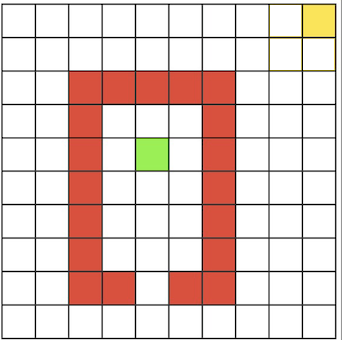

In this environment, there are 100 states and 4 possible
actions: right, up, left, and down. The goal of the agent is to move, via a series of steps, from the start (green) location to the goal (yellow) region, while avoiding the red walls. More specifically:
* The agent starts in the green state,
* Moving into one of the red states incurs a reward of -1,
* Moving into the world borders stays in the same place,
* Moving into the goal state (yellow square in the upper right corner) gives you a reward of 1, and
* Moving anywhere from the goal state ends the episode.

Now that we have our environment and task defined, how can we solve this using a model-based RL agent?

---
## Part 1: DYNA Q Model

The key idea of **DYNA-Q** is to make learning more efficient by adding to the training data. You can think of this as a combination of two ideas, namely **Q-Learning**

\begin{align}
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha \big(r_t + \gamma\max_\limits{a} Q(s_{t+1},a_{t+1}) - Q(s_t,a_t)\big)
\end{align}

and learning and using a **model of the environemt**

\begin{align}
P(s',r|s,a)=P(s_{t+1}=s',r_{t+1}=r|s_t=s,a_t=a)
\end{align}


The key idea is that agents build a model of the task, called $Model(S,A)$. With every experience, they store state-action-reward-state statistics of that experience:

$Model(S,A)$ &larr; $R,S'$

And during breaks ('offline rest'), they can sample from this experience and learn from these samples:


$S$ &larr; previously observed state <br>
$A$ &larr; action previously taken in $S$ <br>
$R,S'$ &larr; $Model(S,A)$ <br>
$Q(S,A)$ &larr; $Q(S,A) + \alpha \left[R + \gamma \max_{a} Q(S',A) - Q(S,A)\right]$

Can you see how this algorithm can help with learning? Are there also situations where it can hurt?

## Task 1: Implement model function

We are looking for a function called '**dyna_q_model_update()**' that stores an experienced reward and next state as illustrated above. 

Think about how this might work (it's very simple). What are the required inputs to the function? You can use the partial solution for hints.

In [5]:
# Your code goes here..

In [6]:
# @title Partial Solution

def dyna_q_model_update(model, state, action, reward, next_state):
    """ 
    Dyna-Q model update

    Args:    
    model (ndarray): An array of shape (n_states, n_actions, 2) that represents
                     the model of the world i.e. what reward and next state do
                     we expect from taking an action in a state.
    state (int): the current state identifier
    action (int): the action taken
    reward (float): the reward received
    next_state (int): the transitioned to state identifier

    Returns:
    ndarray: the updated model
    """

    # Update our model with the observed reward and next state
    # YOUR CODE HERE
    model[state,action] = reward, next_state

    return model

---
## Part 2: DYNA Q in action

In [7]:
def dyna_q_learning(model, value, params):
    """ 
    Dyna-Q learning

    Args:    
    model: An array of shape (n_states, n_actions, 2) that represents
                     the model of the world i.e. what reward and next state do
                     we expect from taking an action in a state.
    value: current value function of shape (n_states, n_actions)
    params: a dictionary containing learning parameters

    Returns:
    Updated value function of shape (n_states, n_actions) 
    """

    # Perform k additional updates at random 
    for n_updates in range(params['k']):

        # Find state-action combinations for which we've experienced a reward i.e.
        # the reward value is not NaN. 
        # The outcome of this expression is an Nx2 matrix, 
        # where each row is a state and action value, respectively.
        candidates = np.array(np.where(~np.isnan(model[:,:,0]))).T

        # Write an expression for selecting a random row index from our candidates
        idx = np.random.choice(len(candidates))

        # Obtain the randomly selected state and action values from the candidates
        state, action = candidates[idx]

        # Obtain the expected reward and next state from the model
        reward, next_state = model[state, action]

        # Update the value function using Q-learning
        value = q_learning(state, action, reward, next_state, value, params)

    return value

Can you figure out which aspect of DYNA-Q the above code (in dyna_q_learning()) is implementing?

Finally, we can use the above functions to implement a learning function for a given environment:

In [8]:
def learn_environment(model_updater, planner, params, max_steps, n_episodes, 
                      n_states = 100, n_actions = 4, init_state = 54): 
  
    # Start with a uniform value function
    value = np.ones((n_states, n_actions))
  
    # Run learning
    reward_sums = np.zeros(n_episodes)
    episode_steps = np.zeros(n_episodes)

    # Dyna-Q state
    model = np.nan*np.zeros((n_states, n_actions, 2))

    # Loop over episodes
    for episode in range(n_episodes):     

        state = init_state  # initialize state
        reward_sum = 0

        for t in range(max_steps):
            # choose next action
            action = epsilon_greedy(value[state], params['epsilon'])

            # observe outcome of action on environment
            next_state, reward = get_outcome(state, action)

            # sum rewards obtained
            reward_sum += reward

            # update value function
            value = q_learning(state, action, reward, next_state, value, params)

            # update model      
            model = model_updater(model, state, action, reward, next_state)
            # execute planner
            value = planner(model, value, params)

            if next_state is None:
                break  # episode ends
            state = next_state      

        reward_sums[episode] = reward_sum
        episode_steps[episode] = t+1

    return value, reward_sums, episode_steps

Now, let's take a look at how the algorithm performs in the above task:

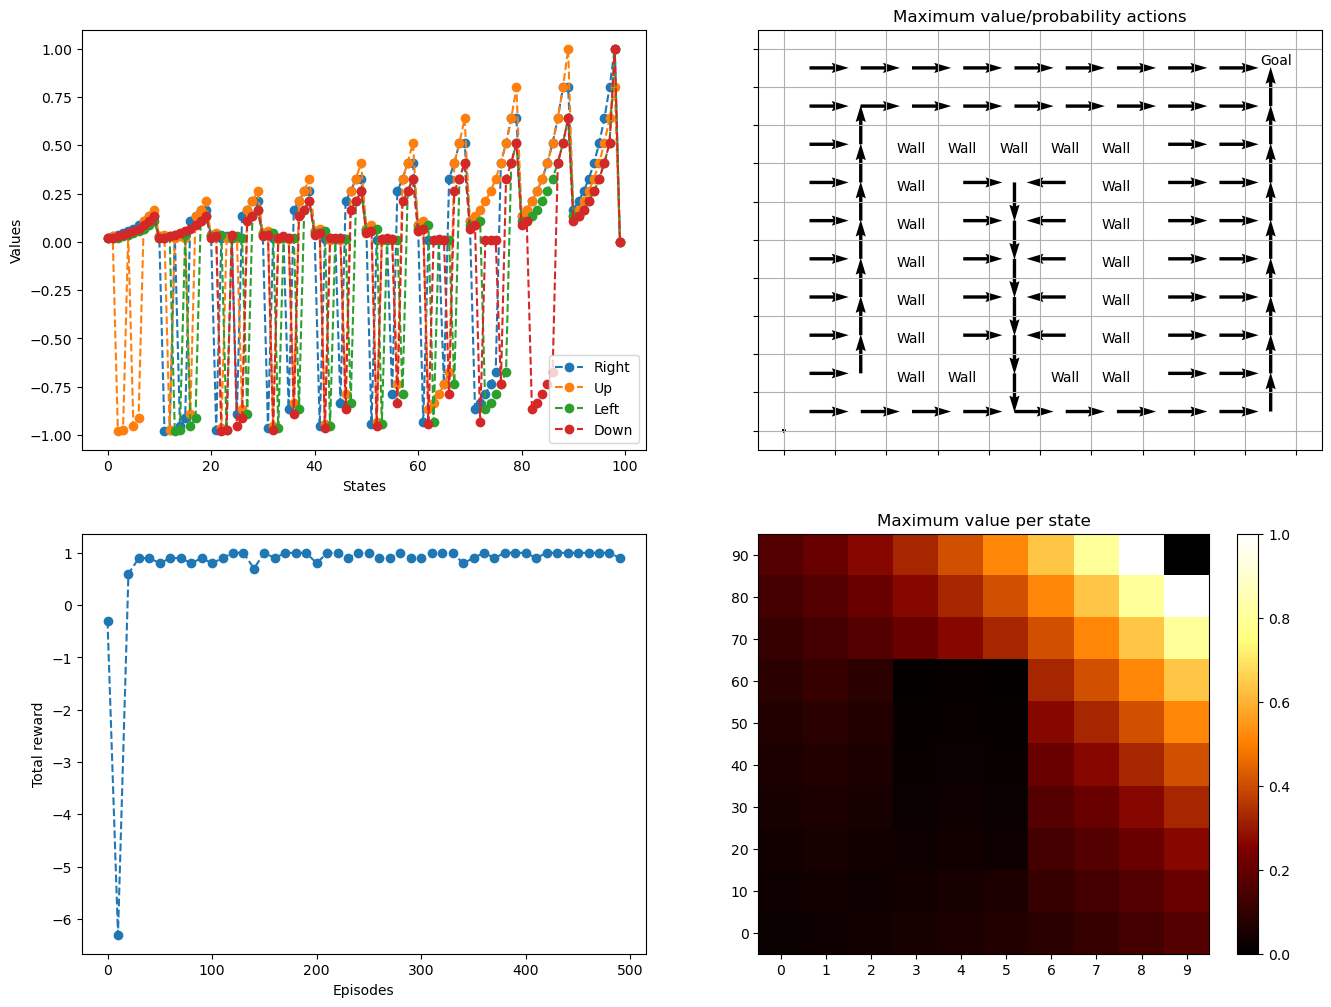

In [13]:
# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

# parameters needed by our policy and learning rule
params = {
  'epsilon': 0.05,  # epsilon-greedy policy
  'alpha': 0.5,  # learning rate    
  'gamma': 0.8,  # temporal discount factor
  'k': 10,  # number of Dyna-Q learning steps
}

# episodes/trials
n_episodes = 500
max_steps = 1000

# solve this task using Dyna-Q
results = learn_environment(dyna_q_model_update, dyna_q_learning,
                            params, max_steps, n_episodes)

value, reward_sums, episode_steps = results

plot_performance(value, reward_sums)

plt.savefig("hw03_figure1.png", dpi=150, bbox_inches='tight')

Can you make sense of the plots above?

---
## Part 3: DYNA Q - how much to sample?

The below simulations show performance under different amounts of sampled learning:

Sim for planning steps 0 done.
Sim for planning steps 1 done.
Sim for planning steps 10 done.
Sim for planning steps 30 done.


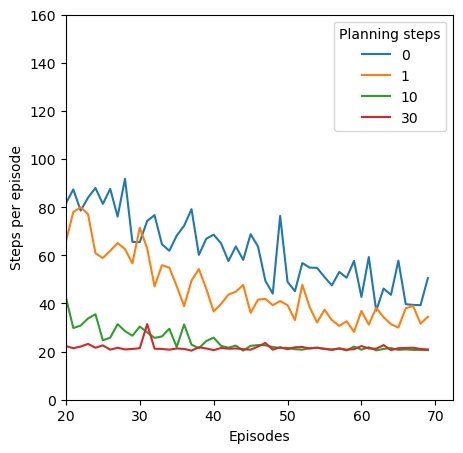

In [11]:
# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

# parameters needed by our policy and learning rule
params = {
  'epsilon': 0.05,  # epsilon-greedy policy
  'alpha': 0.5,  # learning rate    
  'gamma': 0.8,  # temporal discount factor
}

# episodes/trials
n_experiments = 10
n_episodes = 70
max_steps = 100

# number of planning steps
planning_steps = np.array([0, 1, 10, 30])

steps_per_episode = np.zeros((len(planning_steps), n_experiments, n_episodes))

for i, k in enumerate(planning_steps):
    params['k'] = k
    for experiment in range(n_experiments):
        results = learn_environment(dyna_q_model_update, dyna_q_learning,
                                params, max_steps, n_episodes)
        steps_per_episode[i, experiment] = results[2]
    print("Sim for planning steps " + str(k) + " done.")

# Average across experiments
steps_per_episode = np.mean(steps_per_episode, axis=1)

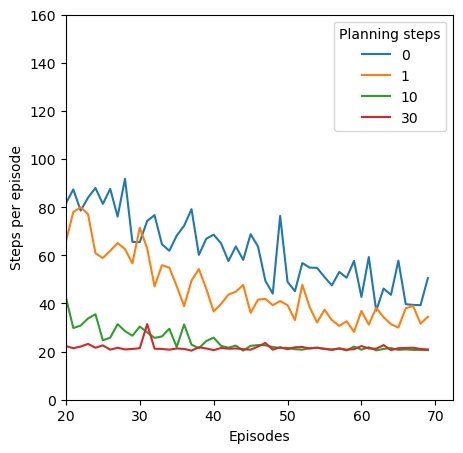

In [12]:
# Plot results
plt.rcParams['figure.figsize'] = [5, 5]
plt.plot(steps_per_episode.T)
plt.xlabel('Episodes')
plt.ylabel('Steps per episode')
plt.xlim([20, None])
plt.ylim([0, 160])
plt.legend(planning_steps, loc='upper right', title="Planning steps")
plt.savefig("hw03_figure2.png", dpi=100, bbox_inches='tight')
plt.show()

What do these results show? Can you tell how this is implicated in the code?

---
## Part 4: Changing the environment

We can now also simulate a situation where a shortcut is introduced. Let's assume that after 200 episodes, something like this appears:

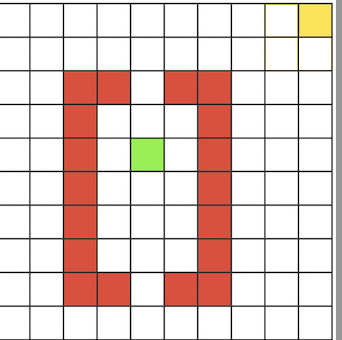

Let's further assume that the agent experiences this shortcut exactly once (if you're interested in how this works, you can check the function learn_environment() in the helper functions).

An interesting question now is to observe how long it takes a Q-learner and a DYNA-Q agent to learn about the new (shorter) path to the goal.

## Task 2: Implement a shortcut

Define a new function called "learn_environment_wShortcut" that takes an additional input 'shortcut_episode'. If the current episode is the shortcut_episode, then you should force the agent to exeperience the shortcut above **once** - simply add this experience to the training loop. Have a go yourself, and if you are stuck you can check the partial solution below.

In [2]:
# Your code goes here..

In [38]:
# @title Partial Solution
def learn_environment_wShortcut(model_updater, planner, params, max_steps, n_episodes, shortcut_episode=200, 
                      n_states = 100, n_actions = 4, init_state = 54, shortcut_state = 64): 
  
    # Start with a uniform value function
    value = np.ones((n_states, n_actions))

    # Run learning
    reward_sums = np.zeros(n_episodes)
    episode_steps = np.zeros(n_episodes)

    # Dyna-Q state
    model = np.nan*np.zeros((n_states, n_actions, 2))

    # Loop over episodes
    for episode in range(n_episodes):
        if shortcut_episode is not None and episode == shortcut_episode: 
            shortcut_state = shortcut_state
          # # experience the transition ONCE: 
            state = shortcut_state
            action = epsilon_greedy(value[state], params['epsilon'])
            next_state, reward = get_outcome(state, action, shortcut_state)
            reward = 1  # default reward value
            print(model.shape)
            print(next_state)
            print(action)
            model[state, action] = reward, next_state
            value = q_learning(state, action, reward, next_state, value, params)      

    state = init_state  # initialize state
    reward_sum = 0

    for t in range(max_steps):
        # choose next action
        action = epsilon_greedy(value[state], params['epsilon'])

        # observe outcome of action on environment
        next_state, reward = get_outcome(state, action, shortcut_state)

        # sum rewards obtained
        reward_sum += reward

        # update value function
        value = q_learning(state, action, reward, next_state, value, params)

        # update model      
        model = model_updater(model, state, action, reward, next_state)
        # execute planner
        value = planner(model, value, params)

        if next_state is None:
            break  # episode ends
        state = next_state      
      
    reward_sums[episode] = reward_sum
    episode_steps[episode] = t+1
  
    return value, reward_sums, episode_steps

(100, 4, 2)
65
0
Sim for planning steps 0 done.
(100, 4, 2)
65
0
Sim for planning steps 10 done.


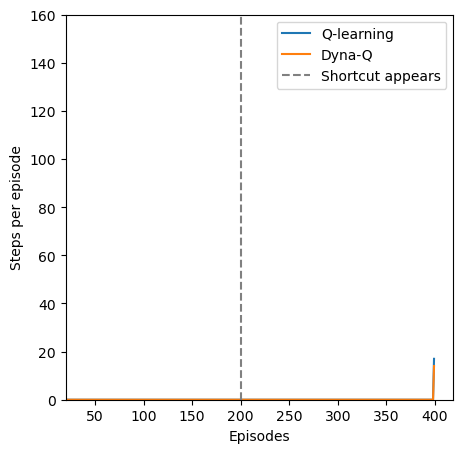

In [39]:
# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

# parameters needed by our policy and learning rule
params = {
  'epsilon': 0.05,  # epsilon-greedy policy
  'alpha': 0.5,  # learning rate    
  'gamma': 0.8,  # temporal discount factor
}

# episodes/trials
n_episodes = 400
max_steps = 1000
shortcut_episode = 200  # when we introduce the shortcut

# number of planning steps
planning_steps = np.array([0, 10]) # Q-learning, Dyna-Q (k=10)

# environment initialization
steps_per_episode = np.zeros((len(planning_steps), n_episodes))

# Solve the task using Q-learning and Dyna-Q
for i, k in enumerate(planning_steps):
    params['k'] = k
    results = learn_environment_wShortcut(dyna_q_model_update, dyna_q_learning,
                              params, max_steps, n_episodes,
                              shortcut_episode=shortcut_episode)
    steps_per_episode[i] = results[2]
    print("Sim for planning steps " + str(k) + " done.")

# Plot results
plt.rcParams['figure.figsize'] = [5, 5]
plt.plot(steps_per_episode.T)
plt.xlabel('Episodes')
plt.ylabel('Steps per episode')
plt.xlim([20, None])
plt.ylim([0, 160])
plt.axvline(shortcut_episode, linestyle="--", color='gray', label="Shortcut appears")
plt.legend(('Q-learning', 'Dyna-Q', 'Shortcut appears'), 
          loc='upper right')
plt.show()

What do these results indicate about the difference between standard Q-Learning and DYNA-Q?

## Task 3: Explore and describe the role of different parameters, especially $\epsilon$, $\alpha$, $\gamma$, and k